In [1]:
!pip install -q efficientnet

In [2]:
# Asthetics
import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

# General
from kaggle_datasets import KaggleDatasets
from glob import glob
import pandas as pd
import numpy as np
import os
import time
import cv2
import random
import shutil
import math
import re
pd.set_option('display.max_columns', None)

# Visualizations
from PIL import Image
from plotly.subplots import make_subplots
from plotly.offline import iplot
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import plotly.graph_objs as go
import plotly.figure_factory as ff
import plotly.express as px
%matplotlib inline
sns.set(style="whitegrid")

# Machine Learning
# Pre Procesing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
# Models
from sklearn.model_selection import train_test_split, KFold
# Deep Learning
import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
import tensorflow_addons as tfa
from tensorflow_addons.metrics import F1Score, FBetaScore
from tensorflow_addons.callbacks import TQDMProgressBar
from tensorflow.keras.utils import plot_model

#Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

print('TF',tf.__version__)

# Random Seed Fixing
RANDOM_SEED = 42

def seed_everything(seed=RANDOM_SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

seed_everything()

TF 2.4.1


In [3]:
# From https://www.kaggle.com/xhlulu/ranzcr-efficientnet-tpu-training
def auto_select_accelerator():
    TPU_DETECTED = False
    try:
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        print("Running on TPU:", tpu.master())
        TPU_DETECTED =True
    except ValueError:
        strategy = tf.distribute.get_strategy()
    print(f"Running on {strategy.num_replicas_in_sync} replicas")
    
    return strategy, TPU_DETECTED

# CFG

In [4]:
# Model Params
KFOLDS = 4
IMG_SIZES = [256]*KFOLDS
BATCH_SIZES = [64]*KFOLDS
EPOCHS = [15]*KFOLDS
EFF_NETS = [1]*KFOLDS # WHICH EFFICIENTNET B? TO USE

# Model Eval Params
DISPLAY_PLOT = True

# Inference Params
WGTS = [1/KFOLDS]*KFOLDS

In [5]:
strategy, TPU_DETECTED = auto_select_accelerator()
AUTO = tf.data.experimental.AUTOTUNE
REPLICAS = strategy.num_replicas_in_sync

Running on TPU: grpc://10.0.0.2:8470
Running on 8 replicas


In [6]:
from tqdm.notebook import tqdm

files_test_g = []
for i,k in tqdm([(0, 1), (2, 3), (4, 5), (6, 7)]):
    GCS_PATH = KaggleDatasets().get_gcs_path(f'cqt-g2net-test-{i}-{k}')
    files_test_g.extend(np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec'))).tolist())
num_train_files = len(files_test_g)
print('test_files:',num_train_files)

  0%|          | 0/4 [00:00<?, ?it/s]

test_files: 8


# Reading Tfrecords

In [7]:
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_id'                     : tf.io.FixedLenFeature([], tf.string),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    }           
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_image(example['image']), tf.reshape(tf.cast(example['target'], tf.float32), [1])


def read_unlabeled_tfrecord(example, return_image_id):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_id'                     : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return prepare_image(example['image']), example['image_id'] if return_image_id else 0

 
def prepare_image(img, dim=IMG_SIZES[0]):    
    img = tf.image.resize(tf.image.decode_png(img, channels=3), size=(dim, dim))
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [dim,dim, 3])
            
    return img

def count_data_items(fileids):
    n = [int(re.compile(r"-([0-9]*)\.").search(fileid).group(1)) 
         for fileid in fileids]
    return np.sum(n)

# Dataset Creation

In [8]:
def get_dataset(files, shuffle = False, repeat = False, 
                labeled=True, return_image_ids=True, batch_size=16, dim=IMG_SIZES[0]):
    
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ds = ds.cache()
    
    if repeat:
        ds = ds.repeat()
    
    if shuffle: 
        ds = ds.shuffle(1024*2)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_ids), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.batch(batch_size * REPLICAS)
    ds = ds.prefetch(AUTO)
    return ds

# Build Model

In [9]:
EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
        efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]

def build_model(size, ef=0):
    inp = tf.keras.layers.Input(shape=(size, size,3))
    base = EFNS[ef](input_shape=(size,size,3),weights='imagenet',include_top=False)
    
    x = base(inp)
    
    x = tf.keras.layers.GlobalAvgPool2D()(x)
    
    x = tf.keras.layers.Dropout(0.)(x)
    
    x = tf.keras.layers.Dense(1,activation='sigmoid')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    lr_decayed_fn = tf.keras.experimental.CosineDecay(
                              6e-4,
                              820*1,
    )

    opt = tfa.optimizers.AdamW(lr_decayed_fn, learning_rate=7e-4)
    loss = tf.keras.losses.BinaryCrossentropy() 
    model.compile(optimizer=opt,loss=loss,metrics=['AUC'])
    return model

# Evaluate

#########################
#### FOLD 1
27164672/27164032 [==============================] - 1s 0us/step
	Loading model...
	Predict...


0it [00:00, ?it/s]

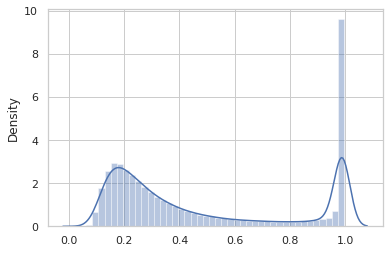

	Finished...
#########################
#### FOLD 2
	Loading model...
	Predict...


0it [00:00, ?it/s]

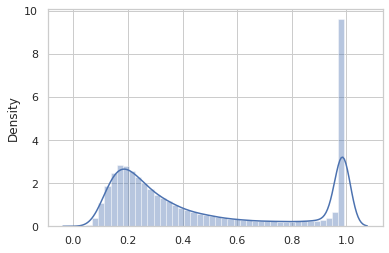

	Finished...
#########################
#### FOLD 3
	Loading model...
	Predict...


0it [00:00, ?it/s]

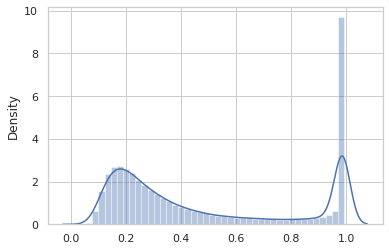

	Finished...
#########################
#### FOLD 4
	Loading model...
	Predict...


0it [00:00, ?it/s]

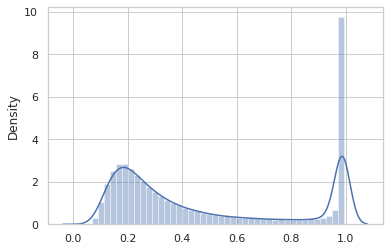

	Finished...


In [10]:
skf = KFold(n_splits=KFOLDS,shuffle=True,random_state=RANDOM_SEED)
oof_pred = []; oof_tar = []; oof_val = []; oof_f1 = []; oof_ids = []; oof_folds = [] 

files_test_g = np.array(files_test_g)

for fold in range(0, KFOLDS):
    
    print('#'*25); print('#### FOLD',fold+1)
    # BUILD MODEL
    K.clear_session()
    
    with strategy.scope():
        model = build_model(IMG_SIZES[fold], ef=EFF_NETS[fold])
    print('\tLoading model...')
    
    model.load_weights(f'../input/cqt-g2net-efficientnetb1-tpu-training/fold-{fold}.h5')  
    
    print('\tPredict...')
    ds_test = get_dataset(files_test_g,labeled=False,return_image_ids=True,
            repeat=False,shuffle=False,dim=IMG_SIZES[fold],batch_size=BATCH_SIZES[fold]*2)
    
    _oof_pred = []
    _oof_tar = []
    for img, target in tqdm(iter(ds_test)):
        p = model.predict(img).flatten()
        t = target.numpy().flatten()
        _oof_pred.extend(p.tolist())
        _oof_tar.extend(t.tolist())
    oof_pred.append(np.array(_oof_pred).flatten())
    oof_ids.append(np.array(_oof_tar).flatten())
    sns.distplot(oof_pred[-1])
    plt.show()               
    print('\tFinished...')

In [11]:
sub = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')
sub['id'] = [t.decode("utf-8") for t in oof_ids[-1]]
sub['target'] = np.mean(oof_pred, axis=0)
sub = sub.sort_values('id') 
sub.head()

,id,target
0,00005bced6,0.990625
8,0000806717,0.749806
16,0000ef4fe1,0.397214
24,00020de251,0.946355
32,00024887b5,0.153290


In [12]:
sub.to_csv('submission.csv', index=False)

# Train Noteboook
* [CQT G2Net EfficientNetB1[TPU Training]](https://www.kaggle.com/miklgr500/cqt-g2net-efficientnetb1-tpu-training)

# Train Datasets
* [Q-Transform TFRecords](https://www.kaggle.com/miklgr500/q-transform-tfrecords)
    * [CQT G2Net V2 [0 - 1]](https://www.kaggle.com/miklgr500/cqt-g2net-v2-0-1)
    * [CQT G2Net V2 [2 - 3]](https://www.kaggle.com/miklgr500/cqt-g2net-v2-2-3)
    * [CQT G2Net V2 [4 - 5]](https://www.kaggle.com/miklgr500/cqt-g2net-v2-4-5)
    * [CQT G2Net V2 [6 - 7]](https://www.kaggle.com/miklgr500/cqt-g2net-v2-6-7)
    * [CQT G2Net V2 [8 - 9]](https://www.kaggle.com/miklgr500/cqt-g2net-v2-8-9)
    * [CQT G2Net V2 [10 - 11]](https://www.kaggle.com/miklgr500/cqt-g2net-v2-10-11)
    * [CQT G2Net V2 [12 - 13]](https://www.kaggle.com/miklgr500/cqt-g2net-v2-12-13)
    * [CQT G2Net V2 [14 - 15]](https://www.kaggle.com/miklgr500/cqt-g2net-v2-14-15)
    
# Test Datasets
* [CQT G2Net Test [0 - 1]](https://www.kaggle.com/miklgr500/cqt-g2net-test-0-1)
* [CQT G2Net Test [2 - 3]](https://www.kaggle.com/miklgr500/cqt-g2net-test-2-3)
* [CQT G2Net Test [4 - 5]](https://www.kaggle.com/miklgr500/cqt-g2net-test-4-5)
* [CQT G2Net Test [6 - 7]](https://www.kaggle.com/miklgr500/cqt-g2net-test-6-7)

# Next steps
* Add augmentation
* Add TTA Inference